In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [2]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu
from suite3d import file_utils as flu
from suite3d import nbtools as nbui
from suite3d import extension as ext

/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/transport.py:258: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [210]:
subjects_dir =   '/mnt/zortex-subjects/'
expt_info = { 
    'subject':         'CR029',
    'date' :          '2024-08-22',
    'expnum' :         2}

tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False)

job_params = {    
    # number of channels recorded in the tiff file, typically 30
    'n_ch_tif' : 26,
    # number of planes in the deeper cavity, typically 15
    'cavity_size' : 13,
    # convert from the Scanimage channel ordering to deep-to-shallow ordering
    # in our case, ScanImage channel numbers are in temporal order. 
    'planes' : n.array([ 0,  2,  4,  6,  8, 10, 12, 14,
                        16, 18, 20, 22, 24, 1,  3, 5,  7,9,11, 13, 15,17,19,21])[3:11],
    # number of files to use for the initial pass
    'n_init_files' :   4,
    
    # number of pixels to fuse between the ROI strips
    # the auto-detection doesn't always work well, recommend 
    # manually tuning it to reduce the stitching artifacts
    'fuse_shift_override' : 6,
    
    # will try to automatically estimate crosstalk using 
    # the shallowest crosstalk_n_planes planes. if you want to override,
    # set override_crosstalk = float between 0 and 1
    'subtract_crosstalk' : False,
    
    # volume rate in acquisition
    'fs' : flu.get_si_params(tifs[0])['vol_rate'],
    
    # 3D GPU registration - fast! 
    # for now, 3D + GPU are well-tested, other options might have minor bugs
    # if you run into them, let us know! we'll fix them
    '3d_reg' : True,
    'gpu_reg' : True,

    'save_dtype' : n.float32,
}


In [211]:

job_params['fs'] = si_params['vol_rate']

savedir = os.path.join('/mnt/md0/runs', expt_info['subject'], expt_info['date'])
os.makedirs(savedir, exist_ok=True)

# Create the job
job = Job('/mnt/md0/runs',exp_str, tifs = tifs,
          params=job_params, create=True, overwrite=True, verbosity = 3)

Job directory /mnt/md0/runs/s3d-CR029_2024-08-22_2 already exists
Loading job directory for CR029_2024-08-22_2 in /mnt/md0/runs
   Loading dirs 
      Found dir registered_fused_data
      Found dir summary
      Found dir iters
   Loading default params
      Updating param n_ch_tif
      Updating param cavity_size
      Updating param planes
      Updating param n_init_files
      Updating param fuse_shift_override
      Updating param subtract_crosstalk
      Updating param fs
      Updating param 3d_reg
      Updating param gpu_reg
      Updating param save_dtype
   Updated main params file


In [212]:
# optional parameters for initialization
# load 1 file to initialize, and select 200 frames randomly to do initalization on
job.params['n_init_files'] = 4
job.params['init_n_frames'] = None
job.params['init_file_sample_method'] = 'even'
job.params['voxel_size_um'] = (20, 3.0, 3.0)

In [213]:
job.run_init_pass()

   Saved a copy of params at /mnt/md0/runs/s3d-CR029_2024-08-22_2/summary
   Updated main params file
Launching initial pass
Saving summary to /mnt/md0/runs/s3d-CR029_2024-08-22_2/summary/summary.npy
   Loading init tifs with 26 channels
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00010.tif
    Loaded file into shared memory in 8.36 sec
    Workers completed in 20.02 sec
    Total time: 28.38 sec
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00019.tif
    Loaded file into shared memory in 8.05 sec
    Workers completed in 25.62 sec
    Total time: 33.67 sec
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00029.tif
    Loaded file into shared memory in 8.28 sec
    Workers completed in 17.15 sec
    Total time: 25.43 sec
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00038.tif
    Loaded file into shared memory in 8.39 sec
    Workers completed i

In [214]:
%%time
job.register()

      Found dir /mnt/md0/runs/s3d-CR029_2024-08-22_2/registered_fused_data
      Updating self.dirs tag registered_fused_data
   Saved a copy of params at /mnt/md0/runs/s3d-CR029_2024-08-22_2/registered_fused_data
   Updated main params file
   Starting registration: 3D: True, GPU: True
   Overriding fuse shift value to 6
   Not clipping frames for registration
Will analyze 47 tifs in 47 batches
   Enforcing positivity
   Launching IO thread
         Memory at batch 0.  Total Used: 310.006 GB, Virtual Available: 208.875 GB, Virtual Used: 294.320 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00001.tif
Loading Batch 0 of 46
    Loaded file into shared memory in 3.93 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 15.85 sec
    Total time: 19.78 sec
   Loaded 1 files, total 0.52 GB
   Batch 0 IO thread joined
         Memory after IO thread joinTotal Used: 310.598 GB, Virtual Available: 208.283 GB, Virtual Used: 294.913 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 311.118 GB, Virtual Available: 207.763 GB, Virtual Used: 295.433 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 271.419 GB, Virtual Available: 247.462 GB, Virtual Used: 255.734 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 271.419 GB, Virtual Available: 247.462 GB, Virtual Used: 255.734 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00002.tif
   Completed rigid reg on batch in :1.1791203022003174s
   Shifted the mov in: 0.30782318115234375s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.15 sec
    Total time: 17.74 sec
   Loaded 1 files, total 0.52 GB
   Batch 1 IO thread joined
         Memory after IO thread joinTotal Used: 271.482 GB, Virtual Available: 247.399 GB, Virtual Used: 255.797 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 271.483 GB, Virtual Available: 247.398 GB, Virtual Used: 255.797 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 270.962 GB, Virtual Available: 247.919 GB, Virtual Used: 255.277 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 270.962 GB, Virtual Available: 247.919 GB, Virtual Used: 255.277 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00003.tif
   Completed rigid reg on batch in :1.1609563827514648s
   Shifted the mov in: 0.3092348575592041s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 9.83 sec
    Total time: 17.33 sec
   Loaded 1 files, total 0.52 GB
   Batch 2 IO thread joined
         Memory after IO thread joinTotal Used: 271.513 GB, Virtual Available: 247.368 GB, Virtual Used: 255.828 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 271.513 GB, Virtual Available: 247.368 GB, Virtual Used: 255.828 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 270.993 GB, Virtual Available: 247.889 GB, Virtual Used: 255.307 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 270.993 GB, Virtual Available: 247.889 GB, Virtual Used: 255.307 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00004.tif
   Completed rigid reg on batch in :1.1666932106018066s
   Shifted the mov in: 0.3076589107513428s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.61 sec
    Total time: 17.54 sec
   Loaded 1 files, total 0.52 GB
   Batch 3 IO thread joined
         Memory after IO thread joinTotal Used: 280.791 GB, Virtual Available: 238.090 GB, Virtual Used: 265.105 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 281.025 GB, Virtual Available: 237.856 GB, Virtual Used: 265.339 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 281.605 GB, Virtual Available: 237.276 GB, Virtual Used: 265.919 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 281.607 GB, Virtual Available: 237.274 GB, Virtual Used: 265.921 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00005.tif
      Loaded batch of size (8, 100, 606, 576)
   Completed rigid reg on batch in :1.1673312187194824s
   Shifted the mov in: 0.3119344711303711s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.95 sec
    Total time: 18.41 sec
   Loaded 1 files, total 0.52 GB
   Batch 4 IO thread joined
         Memory after IO thread joinTotal Used: 272.011 GB, Virtual Available: 246.870 GB, Virtual Used: 256.325 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 272.011 GB, Virtual Available: 246.870 GB, Virtual Used: 256.325 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 271.490 GB, Virtual Available: 247.392 GB, Virtual Used: 255.804 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 271.490 GB, Virtual Available: 247.392 GB, Virtual Used: 255.804 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00006.tif
   Completed rigid reg on batch in :1.1626644134521484s
   Shifted the mov in: 0.3111701011657715s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.24 sec
    Total time: 18.10 sec
   Loaded 1 files, total 0.52 GB
   Batch 5 IO thread joined
         Memory after IO thread joinTotal Used: 279.784 GB, Virtual Available: 239.097 GB, Virtual Used: 264.099 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 280.016 GB, Virtual Available: 238.866 GB, Virtual Used: 264.330 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 280.247 GB, Virtual Available: 238.634 GB, Virtual Used: 264.562 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 280.249 GB, Virtual Available: 238.632 GB, Virtual Used: 264.563 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00007.tif
   Completed rigid reg on batch in :1.1715240478515625s
   Shifted the mov in: 0.3115725517272949s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 9.93 sec
    Total time: 16.70 sec
   Loaded 1 files, total 0.52 GB
   Batch 6 IO thread joined
         Memory after IO thread joinTotal Used: 281.862 GB, Virtual Available: 237.020 GB, Virtual Used: 266.176 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 282.265 GB, Virtual Available: 236.616 GB, Virtual Used: 266.579 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 283.214 GB, Virtual Available: 235.668 GB, Virtual Used: 267.528 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 283.218 GB, Virtual Available: 235.664 GB, Virtual Used: 267.532 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00008.tif
   Completed rigid reg on batch in :1.285715103149414s
   Shifted the mov in: 0.49094629287719727s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 13.71 sec
    Total time: 22.20 sec
   Loaded 1 files, total 0.52 GB
   Batch 7 IO thread joined
         Memory after IO thread joinTotal Used: 284.035 GB, Virtual Available: 234.846 GB, Virtual Used: 268.350 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 284.037 GB, Virtual Available: 234.845 GB, Virtual Used: 268.351 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 283.532 GB, Virtual Available: 235.349 GB, Virtual Used: 267.846 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 283.534 GB, Virtual Available: 235.347 GB, Virtual Used: 267.848 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00009.tif
   Completed rigid reg on batch in :1.278303861618042s
   Shifted the mov in: 0.311018705368042s
         After all GPU Batches:Total

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 15.36 sec
    Total time: 22.32 sec
   Loaded 1 files, total 0.52 GB
   Batch 8 IO thread joined
         Memory after IO thread joinTotal Used: 282.146 GB, Virtual Available: 236.735 GB, Virtual Used: 266.461 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 282.557 GB, Virtual Available: 236.324 GB, Virtual Used: 266.871 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 283.606 GB, Virtual Available: 235.275 GB, Virtual Used: 267.921 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 283.610 GB, Virtual Available: 235.271 GB, Virtual Used: 267.925 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00010.tif
   Completed rigid reg on batch in :1.6797897815704346s
   Shifted the mov in: 0.45669007301330566s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 16.59 sec
    Total time: 25.05 sec
   Loaded 1 files, total 0.52 GB
   Batch 9 IO thread joined
         Memory after IO thread joinTotal Used: 287.073 GB, Virtual Available: 231.808 GB, Virtual Used: 271.388 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 287.074 GB, Virtual Available: 231.808 GB, Virtual Used: 271.388 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 280.589 GB, Virtual Available: 238.292 GB, Virtual Used: 264.903 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 280.590 GB, Virtual Available: 238.291 GB, Virtual Used: 264.905 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00011.tif
   Completed rigid reg on batch in :1.1754510402679443s
   Shifted the mov in: 0.30991291999816895s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 12.44 sec
    Total time: 19.52 sec
   Loaded 1 files, total 0.52 GB
   Batch 10 IO thread joined
         Memory after IO thread joinTotal Used: 279.840 GB, Virtual Available: 239.042 GB, Virtual Used: 264.154 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 280.120 GB, Virtual Available: 238.761 GB, Virtual Used: 264.434 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 280.462 GB, Virtual Available: 238.419 GB, Virtual Used: 264.777 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 280.464 GB, Virtual Available: 238.417 GB, Virtual Used: 264.779 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00012.tif
   Completed rigid reg on batch in :1.4776215553283691s
   Shifted the mov in: 0.5475783348083496s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 16.07 sec
    Total time: 24.47 sec
   Loaded 1 files, total 0.52 GB
   Batch 11 IO thread joined
         Memory after IO thread joinTotal Used: 283.753 GB, Virtual Available: 235.128 GB, Virtual Used: 268.068 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 283.866 GB, Virtual Available: 235.015 GB, Virtual Used: 268.181 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 278.544 GB, Virtual Available: 240.337 GB, Virtual Used: 262.858 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 278.548 GB, Virtual Available: 240.333 GB, Virtual Used: 262.862 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00013.tif
   Completed rigid reg on batch in :1.1784682273864746s
   Shifted the mov in: 0.3199787139892578s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 14.14 sec
    Total time: 22.62 sec
   Loaded 1 files, total 0.52 GB
   Batch 12 IO thread joined
         Memory after IO thread joinTotal Used: 287.254 GB, Virtual Available: 231.628 GB, Virtual Used: 271.568 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 287.316 GB, Virtual Available: 231.565 GB, Virtual Used: 271.630 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 280.945 GB, Virtual Available: 237.937 GB, Virtual Used: 265.259 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 280.945 GB, Virtual Available: 237.937 GB, Virtual Used: 265.259 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00014.tif
   Completed rigid reg on batch in :1.1843700408935547s
   Shifted the mov in: 0.3139491081237793s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.73 sec
    Total time: 17.54 sec
   Loaded 1 files, total 0.52 GB
   Batch 13 IO thread joined
         Memory after IO thread joinTotal Used: 281.248 GB, Virtual Available: 237.633 GB, Virtual Used: 265.562 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 281.317 GB, Virtual Available: 237.564 GB, Virtual Used: 265.632 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 282.005 GB, Virtual Available: 236.876 GB, Virtual Used: 266.319 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 282.009 GB, Virtual Available: 236.872 GB, Virtual Used: 266.324 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00015.tif
   Completed rigid reg on batch in :1.553603172302246s
   Shifted the mov in: 0.48320603370666504s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 16.29 sec
    Total time: 24.77 sec
   Loaded 1 files, total 0.52 GB
   Batch 14 IO thread joined
         Memory after IO thread joinTotal Used: 279.197 GB, Virtual Available: 239.684 GB, Virtual Used: 263.512 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 279.647 GB, Virtual Available: 239.234 GB, Virtual Used: 263.962 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 280.467 GB, Virtual Available: 238.414 GB, Virtual Used: 264.781 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 280.467 GB, Virtual Available: 238.414 GB, Virtual Used: 264.781 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00016.tif
   Completed rigid reg on batch in :1.1880147457122803s
   Shifted the mov in: 0.31654882431030273s
         After all GPU Batches:T

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 16.76 sec
    Total time: 26.22 sec
   Loaded 1 files, total 0.52 GB
   Batch 15 IO thread joined
         Memory after IO thread joinTotal Used: 287.239 GB, Virtual Available: 231.642 GB, Virtual Used: 271.554 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 287.290 GB, Virtual Available: 231.591 GB, Virtual Used: 271.604 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 280.681 GB, Virtual Available: 238.200 GB, Virtual Used: 264.996 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 280.681 GB, Virtual Available: 238.200 GB, Virtual Used: 264.996 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00017.tif
   Completed rigid reg on batch in :1.1780760288238525s
   Shifted the mov in: 0.3136250972747803s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.30 sec
    Total time: 18.39 sec
   Loaded 1 files, total 0.52 GB
   Batch 16 IO thread joined
         Memory after IO thread joinTotal Used: 271.915 GB, Virtual Available: 246.966 GB, Virtual Used: 256.230 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 271.915 GB, Virtual Available: 246.966 GB, Virtual Used: 256.230 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 271.396 GB, Virtual Available: 247.485 GB, Virtual Used: 255.711 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 271.396 GB, Virtual Available: 247.485 GB, Virtual Used: 255.711 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00018.tif
   Completed rigid reg on batch in :1.167337417602539s
   Shifted the mov in: 0.3115522861480713s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 12.86 sec
    Total time: 20.98 sec
   Loaded 1 files, total 0.52 GB
   Batch 17 IO thread joined
         Memory after IO thread joinTotal Used: 277.220 GB, Virtual Available: 241.662 GB, Virtual Used: 261.534 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 277.293 GB, Virtual Available: 241.588 GB, Virtual Used: 261.608 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 277.406 GB, Virtual Available: 241.476 GB, Virtual Used: 261.720 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 277.408 GB, Virtual Available: 241.473 GB, Virtual Used: 261.723 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00019.tif
   Completed rigid reg on batch in :1.5482444763183594s
   Shifted the mov in: 0.44998788833618164s
         After all GPU Batches:T

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 16.57 sec
    Total time: 25.64 sec
   Loaded 1 files, total 0.52 GB
   Batch 18 IO thread joined
         Memory after IO thread joinTotal Used: 281.915 GB, Virtual Available: 236.966 GB, Virtual Used: 266.230 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 282.099 GB, Virtual Available: 236.782 GB, Virtual Used: 266.414 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 277.345 GB, Virtual Available: 241.536 GB, Virtual Used: 261.659 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 277.349 GB, Virtual Available: 241.533 GB, Virtual Used: 261.663 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00020.tif
   Completed rigid reg on batch in :1.1799211502075195s
   Shifted the mov in: 0.30647730827331543s
         After all GPU Batches:T

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.01 sec
    Total time: 18.10 sec
   Loaded 1 files, total 0.52 GB
   Batch 19 IO thread joined
         Memory after IO thread joinTotal Used: 284.824 GB, Virtual Available: 234.057 GB, Virtual Used: 269.138 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 284.824 GB, Virtual Available: 234.058 GB, Virtual Used: 269.138 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 284.303 GB, Virtual Available: 234.578 GB, Virtual Used: 268.617 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 284.303 GB, Virtual Available: 234.578 GB, Virtual Used: 268.617 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00021.tif
      Loaded batch of size (8, 100, 606, 576)
   Completed rigid reg on batch in :1.2283961772918701s
   Shifted the mov in: 0.30995965003967285s
         After all GPU Batches:T

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.04 sec
    Total time: 17.00 sec
   Loaded 1 files, total 0.52 GB
   Batch 20 IO thread joined
         Memory after IO thread joinTotal Used: 272.270 GB, Virtual Available: 246.611 GB, Virtual Used: 256.584 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 272.270 GB, Virtual Available: 246.611 GB, Virtual Used: 256.584 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 271.749 GB, Virtual Available: 247.132 GB, Virtual Used: 256.063 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 271.749 GB, Virtual Available: 247.132 GB, Virtual Used: 256.063 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00022.tif
   Completed rigid reg on batch in :1.1698198318481445s
   Shifted the mov in: 0.3096628189086914s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.35 sec
    Total time: 17.84 sec
   Loaded 1 files, total 0.52 GB
   Batch 21 IO thread joined
         Memory after IO thread joinTotal Used: 272.414 GB, Virtual Available: 246.467 GB, Virtual Used: 256.729 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 272.415 GB, Virtual Available: 246.467 GB, Virtual Used: 256.729 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 271.894 GB, Virtual Available: 246.987 GB, Virtual Used: 256.208 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 271.894 GB, Virtual Available: 246.987 GB, Virtual Used: 256.208 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00023.tif
   Completed rigid reg on batch in :1.163421392440796s
   Shifted the mov in: 0.3088037967681885s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 17.14 sec
    Total time: 24.95 sec
   Loaded 1 files, total 0.52 GB
   Batch 22 IO thread joined
         Memory after IO thread joinTotal Used: 282.817 GB, Virtual Available: 236.065 GB, Virtual Used: 267.131 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 282.931 GB, Virtual Available: 235.950 GB, Virtual Used: 267.245 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 283.147 GB, Virtual Available: 235.735 GB, Virtual Used: 267.461 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 283.147 GB, Virtual Available: 235.735 GB, Virtual Used: 267.461 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00024.tif
   Completed rigid reg on batch in :1.2040128707885742s
   Shifted the mov in: 0.3066141605377197s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 16.71 sec
    Total time: 26.38 sec
   Loaded 1 files, total 0.52 GB
   Batch 23 IO thread joined
         Memory after IO thread joinTotal Used: 287.298 GB, Virtual Available: 231.583 GB, Virtual Used: 271.612 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 287.328 GB, Virtual Available: 231.553 GB, Virtual Used: 271.642 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 271.606 GB, Virtual Available: 247.275 GB, Virtual Used: 255.921 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 271.606 GB, Virtual Available: 247.275 GB, Virtual Used: 255.921 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00025.tif
   Completed rigid reg on batch in :1.1552104949951172s
   Shifted the mov in: 0.3017861843109131s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.56 sec
    Total time: 17.82 sec
   Loaded 1 files, total 0.52 GB
   Batch 24 IO thread joined
         Memory after IO thread joinTotal Used: 274.570 GB, Virtual Available: 244.312 GB, Virtual Used: 258.884 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 275.082 GB, Virtual Available: 243.799 GB, Virtual Used: 259.397 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 273.878 GB, Virtual Available: 245.003 GB, Virtual Used: 258.193 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 273.878 GB, Virtual Available: 245.003 GB, Virtual Used: 258.193 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00026.tif
   Completed rigid reg on batch in :1.155867099761963s
   Shifted the mov in: 0.3405172824859619s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.25 sec
    Total time: 17.58 sec
   Loaded 1 files, total 0.52 GB
   Batch 25 IO thread joined
         Memory after IO thread joinTotal Used: 272.444 GB, Virtual Available: 246.437 GB, Virtual Used: 256.759 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 272.444 GB, Virtual Available: 246.437 GB, Virtual Used: 256.758 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 271.951 GB, Virtual Available: 246.930 GB, Virtual Used: 256.265 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 271.951 GB, Virtual Available: 246.930 GB, Virtual Used: 256.265 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00027.tif
   Completed rigid reg on batch in :1.1506469249725342s
   Shifted the mov in: 0.31121206283569336s
         After all GPU Batches:T

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 16.60 sec
    Total time: 25.55 sec
   Loaded 1 files, total 0.52 GB
   Batch 26 IO thread joined
         Memory after IO thread joinTotal Used: 281.794 GB, Virtual Available: 237.087 GB, Virtual Used: 266.108 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 281.951 GB, Virtual Available: 236.930 GB, Virtual Used: 266.265 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 282.249 GB, Virtual Available: 236.632 GB, Virtual Used: 266.563 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 282.243 GB, Virtual Available: 236.638 GB, Virtual Used: 266.558 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00028.tif
   Completed rigid reg on batch in :1.5625953674316406s
   Shifted the mov in: 0.510063648223877s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 17.02 sec
    Total time: 26.75 sec
   Loaded 1 files, total 0.52 GB
   Batch 27 IO thread joined
         Memory after IO thread joinTotal Used: 286.094 GB, Virtual Available: 232.787 GB, Virtual Used: 270.409 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 286.180 GB, Virtual Available: 232.701 GB, Virtual Used: 270.495 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 286.413 GB, Virtual Available: 232.468 GB, Virtual Used: 270.727 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 286.415 GB, Virtual Available: 232.466 GB, Virtual Used: 270.730 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00029.tif
   Completed rigid reg on batch in :1.161156415939331s
   Shifted the mov in: 0.3123362064361572s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.31 sec
    Total time: 17.54 sec
   Loaded 1 files, total 0.52 GB
   Batch 28 IO thread joined
         Memory after IO thread joinTotal Used: 287.430 GB, Virtual Available: 231.451 GB, Virtual Used: 271.744 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 287.430 GB, Virtual Available: 231.451 GB, Virtual Used: 271.744 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 286.912 GB, Virtual Available: 231.969 GB, Virtual Used: 271.227 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 286.912 GB, Virtual Available: 231.969 GB, Virtual Used: 271.227 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00030.tif
   Completed rigid reg on batch in :1.1552534103393555s
   Shifted the mov in: 0.3133978843688965s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 22.07 sec
    Total time: 30.70 sec
   Loaded 1 files, total 0.52 GB
   Batch 29 IO thread joined
         Memory after IO thread joinTotal Used: 290.201 GB, Virtual Available: 228.680 GB, Virtual Used: 274.515 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 290.367 GB, Virtual Available: 228.514 GB, Virtual Used: 274.681 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 290.735 GB, Virtual Available: 228.146 GB, Virtual Used: 275.049 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 290.737 GB, Virtual Available: 228.144 GB, Virtual Used: 275.052 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00031.tif
   Completed rigid reg on batch in :1.1766412258148193s
   Shifted the mov in: 0.3176155090332031s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.32 sec
    Total time: 17.86 sec
   Loaded 1 files, total 0.52 GB
   Batch 30 IO thread joined
         Memory after IO thread joinTotal Used: 287.665 GB, Virtual Available: 231.216 GB, Virtual Used: 271.980 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 287.665 GB, Virtual Available: 231.216 GB, Virtual Used: 271.980 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 287.159 GB, Virtual Available: 231.722 GB, Virtual Used: 271.474 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 287.159 GB, Virtual Available: 231.722 GB, Virtual Used: 271.474 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00032.tif
   Completed rigid reg on batch in :1.1621334552764893s
   Shifted the mov in: 0.3022322654724121s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.29 sec
    Total time: 18.54 sec
   Loaded 1 files, total 0.52 GB
   Batch 31 IO thread joined
         Memory after IO thread joinTotal Used: 287.845 GB, Virtual Available: 231.037 GB, Virtual Used: 272.159 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 287.845 GB, Virtual Available: 231.036 GB, Virtual Used: 272.159 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 287.324 GB, Virtual Available: 231.557 GB, Virtual Used: 271.638 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 287.324 GB, Virtual Available: 231.557 GB, Virtual Used: 271.638 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00033.tif
   Completed rigid reg on batch in :1.1552817821502686s
   Shifted the mov in: 0.31377172470092773s
         After all GPU Batches:T

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.17 sec
    Total time: 17.60 sec
   Loaded 1 files, total 0.52 GB
   Batch 32 IO thread joined
         Memory after IO thread joinTotal Used: 287.820 GB, Virtual Available: 231.062 GB, Virtual Used: 272.134 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 287.820 GB, Virtual Available: 231.062 GB, Virtual Used: 272.134 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 287.299 GB, Virtual Available: 231.582 GB, Virtual Used: 271.613 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 287.299 GB, Virtual Available: 231.582 GB, Virtual Used: 271.613 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00034.tif
   Completed rigid reg on batch in :1.1625075340270996s
   Shifted the mov in: 0.31060242652893066s
         After all GPU Batches:T

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.22 sec
    Total time: 17.29 sec
   Loaded 1 files, total 0.52 GB
   Batch 33 IO thread joined
         Memory after IO thread joinTotal Used: 287.692 GB, Virtual Available: 231.189 GB, Virtual Used: 272.006 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 287.693 GB, Virtual Available: 231.188 GB, Virtual Used: 272.007 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 287.175 GB, Virtual Available: 231.707 GB, Virtual Used: 271.489 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 287.175 GB, Virtual Available: 231.707 GB, Virtual Used: 271.489 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00035.tif
   Completed rigid reg on batch in :1.4111406803131104s
   Shifted the mov in: 0.46658849716186523s
         After all GPU Batches:T

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 11.22 sec
    Total time: 18.56 sec
   Loaded 1 files, total 0.52 GB
   Batch 34 IO thread joined
         Memory after IO thread joinTotal Used: 287.804 GB, Virtual Available: 231.078 GB, Virtual Used: 272.118 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 287.804 GB, Virtual Available: 231.078 GB, Virtual Used: 272.118 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 287.283 GB, Virtual Available: 231.598 GB, Virtual Used: 271.598 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 287.283 GB, Virtual Available: 231.598 GB, Virtual Used: 271.598 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00036.tif
   Completed rigid reg on batch in :1.1645534038543701s
   Shifted the mov in: 0.3041198253631592s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.60 sec
    Total time: 18.08 sec
   Loaded 1 files, total 0.52 GB
   Batch 35 IO thread joined
         Memory after IO thread joinTotal Used: 287.445 GB, Virtual Available: 231.436 GB, Virtual Used: 271.759 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 287.446 GB, Virtual Available: 231.435 GB, Virtual Used: 271.761 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 286.937 GB, Virtual Available: 231.944 GB, Virtual Used: 271.252 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 286.931 GB, Virtual Available: 231.950 GB, Virtual Used: 271.246 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00037.tif
   Completed rigid reg on batch in :1.2546184062957764s
   Shifted the mov in: 0.35333943367004395s
         After all GPU Batches:T

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.50 sec
    Total time: 18.41 sec
   Loaded 1 files, total 0.52 GB
   Batch 36 IO thread joined
         Memory after IO thread joinTotal Used: 287.666 GB, Virtual Available: 231.215 GB, Virtual Used: 271.980 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 287.671 GB, Virtual Available: 231.210 GB, Virtual Used: 271.985 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 287.145 GB, Virtual Available: 231.736 GB, Virtual Used: 271.460 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 287.147 GB, Virtual Available: 231.734 GB, Virtual Used: 271.462 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00038.tif
   Completed rigid reg on batch in :1.365734338760376s
   Shifted the mov in: 0.4515964984893799s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 9.81 sec
    Total time: 17.30 sec
   Loaded 1 files, total 0.52 GB
   Batch 37 IO thread joined
         Memory after IO thread joinTotal Used: 287.617 GB, Virtual Available: 231.265 GB, Virtual Used: 271.931 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 287.615 GB, Virtual Available: 231.266 GB, Virtual Used: 271.930 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 287.089 GB, Virtual Available: 231.792 GB, Virtual Used: 271.403 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 287.089 GB, Virtual Available: 231.792 GB, Virtual Used: 271.403 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00039.tif
   Completed rigid reg on batch in :1.4797120094299316s
   Shifted the mov in: 0.4971451759338379s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.05 sec
    Total time: 18.20 sec
   Loaded 1 files, total 0.52 GB
   Batch 38 IO thread joined
         Memory after IO thread joinTotal Used: 287.674 GB, Virtual Available: 231.207 GB, Virtual Used: 271.989 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 287.680 GB, Virtual Available: 231.201 GB, Virtual Used: 271.995 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 287.151 GB, Virtual Available: 231.730 GB, Virtual Used: 271.465 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 287.151 GB, Virtual Available: 231.730 GB, Virtual Used: 271.466 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00040.tif
   Completed rigid reg on batch in :1.323056936264038s
   Shifted the mov in: 0.4804236888885498s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 9.95 sec
    Total time: 17.43 sec
   Loaded 1 files, total 0.52 GB
   Batch 39 IO thread joined
         Memory after IO thread joinTotal Used: 287.634 GB, Virtual Available: 231.247 GB, Virtual Used: 271.949 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 287.634 GB, Virtual Available: 231.247 GB, Virtual Used: 271.949 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 287.116 GB, Virtual Available: 231.766 GB, Virtual Used: 271.430 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 287.116 GB, Virtual Available: 231.766 GB, Virtual Used: 271.430 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00041.tif
   Completed rigid reg on batch in :1.157604694366455s
   Shifted the mov in: 0.30403971672058105s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.38 sec
    Total time: 17.31 sec
   Loaded 1 files, total 0.52 GB
   Batch 40 IO thread joined
         Memory after IO thread joinTotal Used: 287.361 GB, Virtual Available: 231.520 GB, Virtual Used: 271.676 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 287.361 GB, Virtual Available: 231.520 GB, Virtual Used: 271.676 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 286.848 GB, Virtual Available: 232.033 GB, Virtual Used: 271.163 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 286.848 GB, Virtual Available: 232.033 GB, Virtual Used: 271.163 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00042.tif
   Completed rigid reg on batch in :1.159949541091919s
   Shifted the mov in: 0.3073396682739258s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.39 sec
    Total time: 20.41 sec
   Loaded 1 files, total 0.52 GB
   Batch 41 IO thread joined
         Memory after IO thread joinTotal Used: 287.502 GB, Virtual Available: 231.379 GB, Virtual Used: 271.817 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 287.502 GB, Virtual Available: 231.379 GB, Virtual Used: 271.817 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 286.978 GB, Virtual Available: 231.903 GB, Virtual Used: 271.292 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 286.978 GB, Virtual Available: 231.903 GB, Virtual Used: 271.292 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00043.tif
   Completed rigid reg on batch in :1.1616506576538086s
   Shifted the mov in: 0.31264352798461914s
         After all GPU Batches:T

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.03 sec
    Total time: 17.22 sec
   Loaded 1 files, total 0.52 GB
   Batch 42 IO thread joined
         Memory after IO thread joinTotal Used: 287.580 GB, Virtual Available: 231.301 GB, Virtual Used: 271.894 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 287.579 GB, Virtual Available: 231.302 GB, Virtual Used: 271.894 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 287.055 GB, Virtual Available: 231.827 GB, Virtual Used: 271.369 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 287.055 GB, Virtual Available: 231.827 GB, Virtual Used: 271.369 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00044.tif
   Completed rigid reg on batch in :1.2702784538269043s
   Shifted the mov in: 0.31808900833129883s
         After all GPU Batches:T

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.06 sec
    Total time: 17.57 sec
   Loaded 1 files, total 0.52 GB
   Batch 43 IO thread joined
         Memory after IO thread joinTotal Used: 287.669 GB, Virtual Available: 231.212 GB, Virtual Used: 271.983 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 287.667 GB, Virtual Available: 231.214 GB, Virtual Used: 271.981 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 287.147 GB, Virtual Available: 231.734 GB, Virtual Used: 271.462 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 287.141 GB, Virtual Available: 231.740 GB, Virtual Used: 271.456 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00045.tif
   Completed rigid reg on batch in :1.3547534942626953s
   Shifted the mov in: 0.3267781734466553s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.20 sec
    Total time: 18.78 sec
   Loaded 1 files, total 0.52 GB
   Batch 44 IO thread joined
         Memory after IO thread joinTotal Used: 287.709 GB, Virtual Available: 231.173 GB, Virtual Used: 272.023 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 287.709 GB, Virtual Available: 231.172 GB, Virtual Used: 272.024 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 287.188 GB, Virtual Available: 231.693 GB, Virtual Used: 271.503 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 287.188 GB, Virtual Available: 231.693 GB, Virtual Used: 271.503 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00046.tif
   Completed rigid reg on batch in :1.3504514694213867s
   Shifted the mov in: 0.41333556175231934s
         After all GPU Batches:T

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.44 sec
    Total time: 17.46 sec
   Loaded 1 files, total 0.52 GB
   Batch 45 IO thread joined
         Memory after IO thread joinTotal Used: 287.742 GB, Virtual Available: 231.139 GB, Virtual Used: 272.057 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 287.748 GB, Virtual Available: 231.133 GB, Virtual Used: 272.063 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 287.222 GB, Virtual Available: 231.659 GB, Virtual Used: 271.537 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 287.223 GB, Virtual Available: 231.658 GB, Virtual Used: 271.538 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-22/2/2024-08-22_2_CR029_2P_00001_00047.tif
   Completed rigid reg on batch in :1.3606584072113037s
   Shifted the mov in: 0.32058000564575195s
         After all GPU Batches:T

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 10.37 sec
    Total time: 13.53 sec
         After full batch saving:Total Used: 294.168 GB, Virtual Available: 224.713 GB, Virtual Used: 278.483 GB, Swap Used: 015.686 GB
         Memory at batch 46. Total Used: 294.168 GB, Virtual Available: 224.713 GB, Virtual Used: 278.483 GB, Swap Used: 015.686 GB
Loading Batch 46 of 46
   Loaded 1 files, total 0.24 GB
   Batch 46 IO thread joined
         Memory after IO thread joinTotal Used: 287.468 GB, Virtual Available: 231.413 GB, Virtual Used: 271.783 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 287.468 GB, Virtual Available: 231.413 GB, Virtual Used: 271.783 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 287.222 GB, Virtual Available: 231.659 GB, Virtual Used: 271.536 GB, Swap Used: 015.686 GB
      Loaded batch of size (8, 47, 606, 576)
   Completed rigid reg on batch in :0.5467567443847656s
   Shifted the mov in: 0.10236167907714844s
       

In [215]:
mov_full = job.get_registered_movie('registered_fused_data', 'fused').astype(n.float32)
im_full = mov_full[:,:100].mean(axis=1).compute()

In [216]:
job.params['voxel_size_um'] = (20, 3.0, 3.0)
job.params['npil_filt_xy_um'] = 70
job.params['npil_filt_type'] = None
job.params['cell_filt_xy_um'] = 3
job.params['sdnorm_exp'] = 0.8
job.params['t_batch_size'] = 500
job.params['intensity_thresh'] = 0.5

In [217]:
%%time
corr_map = job.calculate_corr_map(iter_limit=4, output_dir_name='corrmap')

   Created dir /mnt/md0/runs/s3d-CR029_2024-08-22_2/corrmap with tag corrmap
      Updating self.dirs tag corrmap
   Created dir /mnt/md0/runs/s3d-CR029_2024-08-22_2/corrmap/corrmap with tag corrmap-corrmap
      Updating self.dirs tag corrmap-corrmap
   Created dir /mnt/md0/runs/s3d-CR029_2024-08-22_2/corrmap/mov_sub with tag corrmap-mov_sub
      Updating self.dirs tag corrmap-mov_sub
   Saved a copy of params at /mnt/md0/runs/s3d-CR029_2024-08-22_2/corrmap/corrmap
   Updated main params file
   Computing correlation map of movie with 4647 frames, volume shape: 8, 613, 579
      Running batch 1 of 4
         Timer prep completed in 8.791 sec
         Timer batch_setup completed in 0.505 sec
         Timer batch_edgecrop completed in 0.124 sec
         Timer accum_meanmeax completed in 1.075 sec
         Timer batch_rolling_mean_filt completed in 1.040 sec
         Timer batch_accum_sdmov completed in 59.099 sec
         Timer batch_norm_sdmov completed in 0.591 sec
         Loading m

In [218]:
corr_map = job.load_corr_map_results(parent_dir_name='corrmap')['vmap']
corr_map_thresh = ext.thresh_mask_corr_map(corr_map, thresh_window_size_pix = 51, corrmap_thresh_pct = 60)

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f0013087a00>)

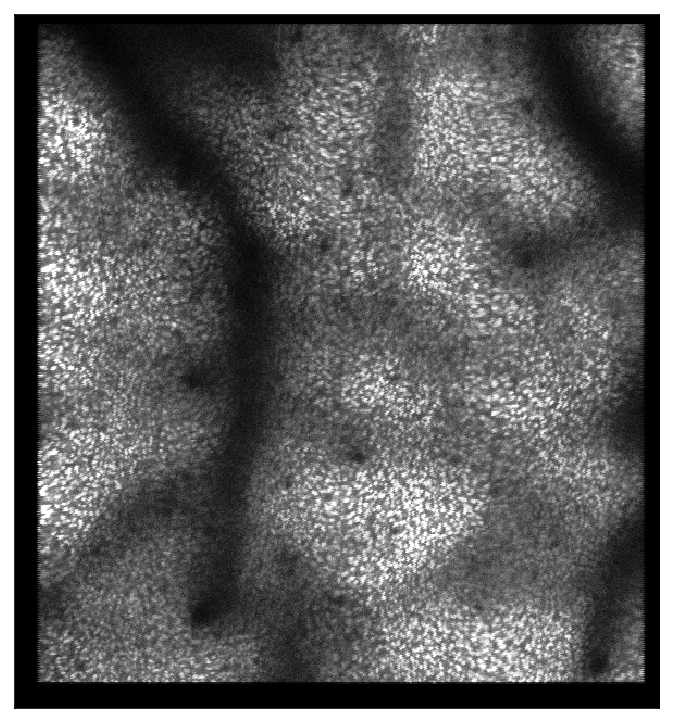

In [221]:
tfu.show_tif(img[5])

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f00134132e0>)

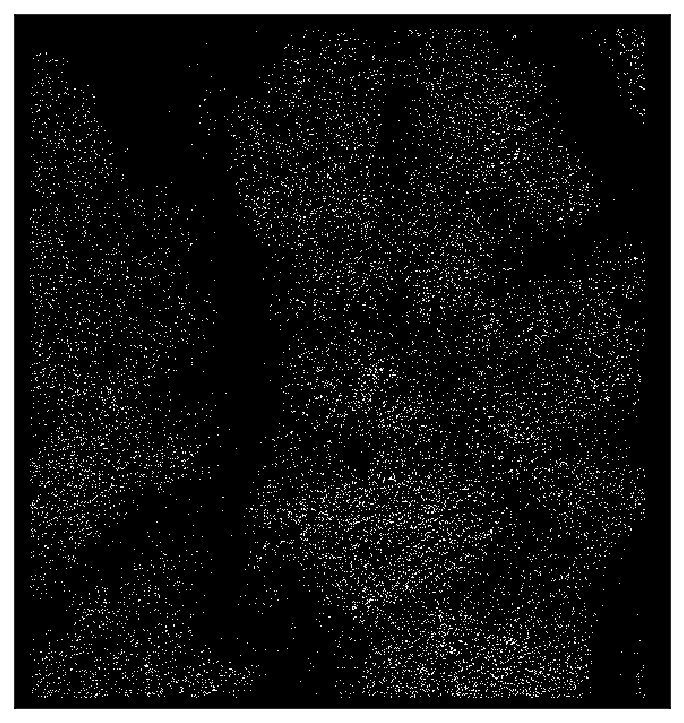

In [226]:
thx = 0.15
tfu.show_tif(corr_map_thresh[5], vminmax=(thx, thx + 1e-6))

In [60]:
%%time
job.params['percentile'] = 99.0 #80.0
job.params['patch_size_xy'] = (120, 120)
job.params['patch_overlap_xy'] = (25, 25)
job.params['extend_thresh'] = 0.025 # 0.0025
job.params['activity_thresh'] = 20.0
job.params['max_iter'] = 3000
job.params['ext_subtract_iters'] = 3
job.params['n_proc_detect'] = 16
job.segment_rois(vmap = corr_map_thresh, ts = (0,2000), patches_to_segment=(21,), input_dir_name='corrmap2',
                output_dir_name='seg2')

      Found dir /mnt/md0/runs/s3d-CR029_2024-08-22_1-2-3-4-5-6-7-8-9-10/seg2/segmentation
      Updating self.dirs tag seg2-segmentation
   Saved a copy of params at /mnt/md0/runs/s3d-CR029_2024-08-22_1-2-3-4-5-6-7-8-9-10/seg2/segmentation
   Updated main params file
      Found dir /mnt/md0/runs/s3d-CR029_2024-08-22_1-2-3-4-5-6-7-8-9-10/seg2/rois
      Updating self.dirs tag seg2-rois
   Saving results to /mnt/md0/runs/s3d-CR029_2024-08-22_1-2-3-4-5-6-7-8-9-10/seg2/segmentation and /mnt/md0/runs/s3d-CR029_2024-08-22_1-2-3-4-5-6-7-8-9-10/seg2/rois 
dict_keys(['max_img', 'mean_img', 'vmap', 'all_params'])
   Detecting from patch 1 / 1
      Found dir /mnt/md0/runs/s3d-CR029_2024-08-22_1-2-3-4-5-6-7-8-9-10/seg2/segmentation/patch-0021
         Loading 0.97 GB movie to memory, shape: (2000, 18, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.001 and Th2: 20.000
         Iter 0000: running 16 ROIs in par

'/mnt/md0/runs/s3d-CR029_2024-08-22_1-2-3-4-5-6-7-8-9-10/seg2/rois'

In [82]:
seg = job.load_segmentation_results(output_dir_name='seg2-rois')

      Loading from /mnt/md0/runs/s3d-CR029_2024-08-22_1-2-3-4-5-6-7-8-9-10/seg2/rois/info.npy
      Loading from /mnt/md0/runs/s3d-CR029_2024-08-22_1-2-3-4-5-6-7-8-9-10/seg2/rois/stats.npy
      Loading from /mnt/md0/runs/s3d-CR029_2024-08-22_1-2-3-4-5-6-7-8-9-10/seg2/rois/iscell.npy


In [100]:
# rres = job.load_registration_results()

# qm0 = rres['metrics'][0].item()
# noises = qm0['noise_levels']

In [86]:
x0, y0= 290, 270
mov = job.get_registered_movie()[:,:2000, y0:y0+120, x0:x0+120].compute()

In [ ]:
cell_idx = 200
stat = seg['stats'][cell_idx]

zz,yy,xx = stat['coords']
mz, my, mx = stat['med']
lam = stat['lam']

npz, npy, npx = stat['npcoords']

fs_roi = mov[zz,:,yy-y0,xx-x0][n.argsort(-lam)]
fs_np = mov[npz, :, npy-y0, npx-x0]
f_roi = (lam @ mov[zz,:,yy-y0,xx-x0])
f_med = (mov[mz, :, my-y0, mx-x0])

fs_roi_corr = n.corrcoef(n.concatenate([[f_roi], fs_roi]))
fs_np_corr = n.corrcoef(n.concatenate([[f_roi], fs_np]))

In [191]:
imx = mov.mean(axis=1)

In [192]:
# bx = n.linspace(-1,1,101)
# plt.hist(fs_np_corr[1:,1:].flatten(), bins = bx, density=True, alpha=0.5);
# plt.hist(fs_roi_corr[1:,1:].flatten(), bins=bx, density=True, alpha=0.5);

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f00139f9d90>)

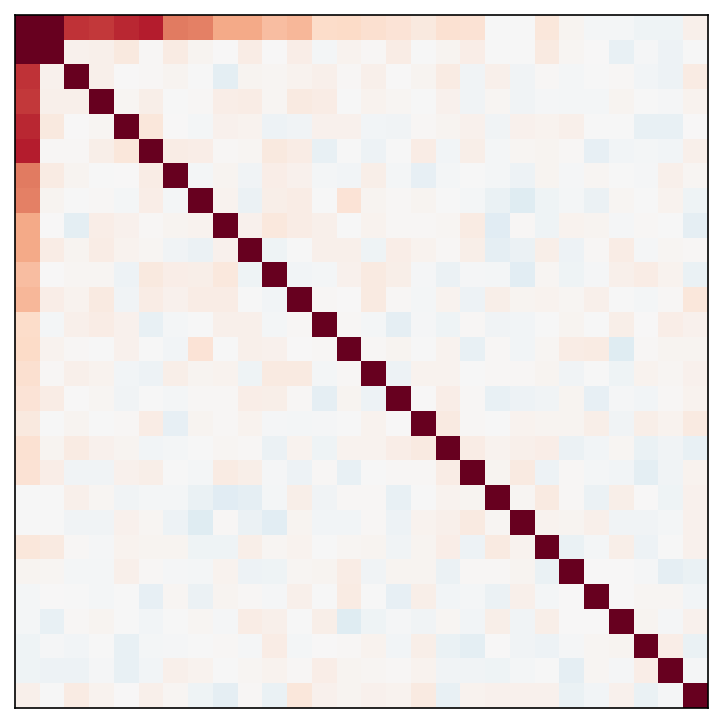

In [193]:
tfu.show_tif(fs_roi_corr, cmap='RdBu_r',vminmax=(-0.5,0.5))

(0.0, 200.0)

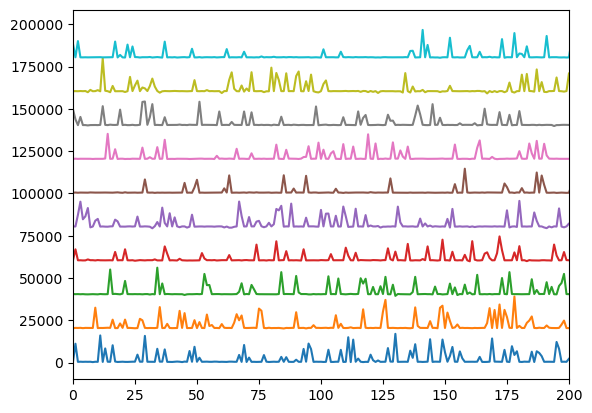

In [196]:
dy = 20000
for i in range(5):
    plt.plot((fs_roi[i]) + i*dy)
for j in range(5):
    plt.plot(fs_np[n.random.choice(n.arange(len(npz)))] + (i+j+1)*dy)
plt.xlim(0,200)

In [62]:
job.compute_npil_masks(stats_dir = job.dirs['seg2-rois'])
job.params['tau'] = 0.15
job.params['npil_coeff'] = 0.0
traces = job.extract_and_deconvolve(stats_dir=job.dirs['seg2-rois'], ts=(0,11000))

   Updated main params file
   Movie shape: (18, 11000, 638, 593)
1136
   Extracting 1136 valid cells, and saving cell flags to /mnt/md0/runs/s3d-CR029_2024-08-22_1-2-3-4-5-6-7-8-9-10/seg2/rois/iscell_extracted.npy
   Extracting activity
         Will extract in 22 batches of 500
   Saving intermediate results to /mnt/md0/runs/s3d-CR029_2024-08-22_1-2-3-4-5-6-7-8-9-10/seg2/rois
   Deconvolving
   Saving to /mnt/md0/runs/s3d-CR029_2024-08-22_1-2-3-4-5-6-7-8-9-10/seg2/rois


In [64]:
job.export_results('/mnt/zeytin-f1/s3d-results/',result_dir_name='seg2-rois', output_dir_label='-subset')

   Created dir /mnt/zeytin-f1/s3d-results/s3d-results-CR029_2024-08-22_1-2-3-4-5-6-7-8-9-10-subset to export results
      Loading from /mnt/md0/runs/s3d-CR029_2024-08-22_1-2-3-4-5-6-7-8-9-10/seg2/rois/stats_small.npy
      Loading from /mnt/md0/runs/s3d-CR029_2024-08-22_1-2-3-4-5-6-7-8-9-10/seg2/rois/info.npy
      Loading from /mnt/md0/runs/s3d-CR029_2024-08-22_1-2-3-4-5-6-7-8-9-10/seg2/rois/F.npy
      Loading from /mnt/md0/runs/s3d-CR029_2024-08-22_1-2-3-4-5-6-7-8-9-10/seg2/rois/spks.npy
      Loading from /mnt/md0/runs/s3d-CR029_2024-08-22_1-2-3-4-5-6-7-8-9-10/seg2/rois/Fneu.npy
      Loading from /mnt/md0/runs/s3d-CR029_2024-08-22_1-2-3-4-5-6-7-8-9-10/seg2/rois/iscell.npy
      Saved stats.npy to /mnt/zeytin-f1/s3d-results/s3d-results-CR029_2024-08-22_1-2-3-4-5-6-7-8-9-10-subset
      Saved info.npy to /mnt/zeytin-f1/s3d-results/s3d-results-CR029_2024-08-22_1-2-3-4-5-6-7-8-9-10-subset
      Saved F.npy to /mnt/zeytin-f1/s3d-results/s3d-results-CR029_2024-08-22_1-2-3-4-5-6-7-8-9-1